Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
!pip install -q IPython
!pip install -q ipykernel
!pip install -q torch
!pip install -q watermark
!pip install -q matplotlib
!pip install -q tensorwatch
!pip install -q sklearn
!pip install -q pandas
!pip install -q pydot
!pip install -q hiddenlayer
!pip install -q graphviz
!pip install -q torchvision
!pip install -q torchtext

     |████████████████████████████████| 194kB 7.3MB/s 
     |████████████████████████████████| 143kB 12.3MB/s 


In [2]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.6.9
IPython 5.5.0

torch 1.5.1+cu101


- Runs on CPU or GPU (if available)

# Model Zoo -- Multilayer Perceptron with BatchNorm

## Imports

In [3]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Settings and Dataset

In [4]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
learning_rate = 0.1
num_epochs = 10
batch_size = 64

# Architecture
num_features = 784
num_hidden_1 = 128
num_hidden_2 = 256
num_classes = 10


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!



Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [5]:
##########################
### MODEL
##########################

class MultilayerPerceptron(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(MultilayerPerceptron, self).__init__()
        
        ### 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        # The following to lones are not necessary, 
        # but used here to demonstrate how to access the weights
        # and use a different weight initialization.
        # By default, PyTorch uses Xavier/Glorot initialization, which
        # should usually be preferred.
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        self.linear_1_bn = torch.nn.BatchNorm1d(num_hidden_1)
        
        ### 2nd hidden layer
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_2.weight.detach().normal_(0.0, 0.1)
        self.linear_2.bias.detach().zero_()
        self.linear_2_bn = torch.nn.BatchNorm1d(num_hidden_2)
        
        ### Output layer
        self.linear_out = torch.nn.Linear(num_hidden_2, num_classes)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()
        
    def forward(self, x):
        out = self.linear_1(x)
        # note that batchnorm is in the classic
        # sense placed before the activation
        out = self.linear_1_bn(out)
        out = F.relu(out)
        
        out = self.linear_2(out)
        out = self.linear_2_bn(out)
        out = F.relu(out)
        
        logits = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
torch.manual_seed(random_seed)
model = MultilayerPerceptron(num_features=num_features,
                             num_classes=num_classes)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

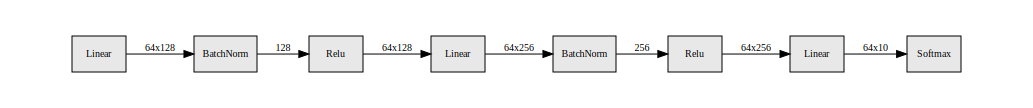

In [8]:
import hiddenlayer as hl
hl.build_graph(model, torch.zeros([64, 784]).to(device))

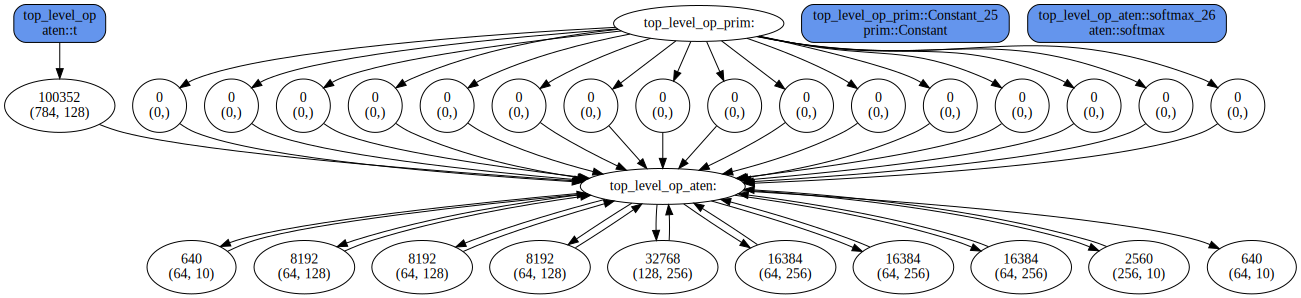

In [9]:
import tensorwatch as tw
tw.draw_model(model, [64, 784])

In [10]:
def compute_accuracy(net, data_loader):
    net.eval()
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(device)
            targets = targets.to(device)
            logits, probas = net(features)
            _, predicted_labels = torch.max(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100

    
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

    print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
          epoch+1, num_epochs, 
          compute_accuracy(model, train_loader)))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/938 | Cost: 2.5287
Epoch: 001/010 | Batch 050/938 | Cost: 0.5931
Epoch: 001/010 | Batch 100/938 | Cost: 0.4121
Epoch: 001/010 | Batch 150/938 | Cost: 0.1960
Epoch: 001/010 | Batch 200/938 | Cost: 0.1789
Epoch: 001/010 | Batch 250/938 | Cost: 0.3476
Epoch: 001/010 | Batch 300/938 | Cost: 0.2571
Epoch: 001/010 | Batch 350/938 | Cost: 0.1699
Epoch: 001/010 | Batch 400/938 | Cost: 0.4255
Epoch: 001/010 | Batch 450/938 | Cost: 0.2882
Epoch: 001/010 | Batch 500/938 | Cost: 0.1355
Epoch: 001/010 | Batch 550/938 | Cost: 0.1459
Epoch: 001/010 | Batch 600/938 | Cost: 0.2932
Epoch: 001/010 | Batch 650/938 | Cost: 0.2294
Epoch: 001/010 | Batch 700/938 | Cost: 0.1631
Epoch: 001/010 | Batch 750/938 | Cost: 0.1825
Epoch: 001/010 | Batch 800/938 | Cost: 0.1547
Epoch: 001/010 | Batch 850/938 | Cost: 0.1627
Epoch: 001/010 | Batch 900/938 | Cost: 0.1151
Epoch: 001/010 training accuracy: 96.47%
Time elapsed: 0.26 min
Epoch: 002/010 | Batch 000/938 | Cost: 0.1339
Epoch: 002/010 |

In [11]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 97.85%


In [12]:
%watermark -iv

numpy 1.18.5
torch 1.5.1+cu101

